In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from pandas import concat

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
# Read Training Data 
train = pd.read_csv(r'C:\Users\Veekesh\data\sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Phase 1: Exploratory Data Analysis and Data Cleaning

In [4]:
# Describe function
round(train.describe(),0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,15.0,33.0,10197.0,891.0,1.0
std,9.0,16.0,6324.0,1730.0,3.0
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


We can notice an item_price to be negative, this has to be handled

In [5]:
# format date
#print(datetime.strptime('02.01.2013','%d.%m.%Y'))

train['date'] = train['date'].apply(lambda x: datetime.strptime(x,'%d.%m.%Y'))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [7]:
# Number of Unique Stores
print('Number of unique stores:', len(train['shop_id'].unique()))

Number of unique stores: 60


In [8]:
# Date Range
print('Min Date:', train['date'].min())
print('Max Date:', train['date'].max())

Min Date: 2013-01-01 00:00:00
Max Date: 2015-10-31 00:00:00


In [9]:
# Date Block Number
print('Min Date Block Number:', train['date_block_num'].min())
print('Max Date Block Number:', train['date_block_num'].max())

Min Date Block Number: 0
Max Date Block Number: 33


In [10]:
# Number of Distinct Items
print('Number of unique items:', len(train['item_id'].unique()))

Number of unique items: 21807


In [11]:
# Item count by day
print('Min number of products sold by day:', train['item_cnt_day'].min())
print('Max number of products sold by day:', train['item_cnt_day'].max())

Min number of products sold by day: -22.0
Max number of products sold by day: 2169.0


**What does the negative value mean??
We can interpret negative values as returned items or remove it from our analysis

In [12]:
# Number of records with negative item_cnt_day
neg = train[train['item_cnt_day'] < 0].shape[0]
pos = train[train['item_cnt_day'] >= 0].shape[0]
percentage_neg = (neg/(neg+pos)) * 100
print('Number of records with negative item_cnt_day: ', neg)
print('Number of records with positive item_cnt_day: ', pos)
print('Percentage of records with negative item_cnt_day: ', str(percentage_neg) + ' %' )

Number of records with negative item_cnt_day:  7356
Number of records with positive item_cnt_day:  2928493
Percentage of records with negative item_cnt_day:  0.2505578454477734 %


In [13]:
#sns.set(style="ticks", color_codes=True)
#g = sns.pairplot(train)

In [14]:
# Correlation Plot
df = train
df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013


In [15]:
df = pd.merge(df, pd.read_csv(r'C:\Users\Veekesh\data\items.csv'), on='item_id')
df = pd.merge(df, pd.read_csv(r'C:\Users\Veekesh\data\item_categories.csv'), on='item_category_id')
itemPriceMean = df.groupby('item_category_name').item_price.mean()

# Sorting the series with mean item price values in descending order
sortedItemPriceMean = itemPriceMean.sort_values(ascending=False)[:5]

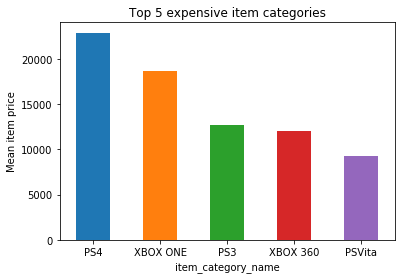

In [16]:
nameList = [x.split(' - ')[1] for x in sortedItemPriceMean.index.tolist()]
srs = sortedItemPriceMean.rename(dict(zip(sortedItemPriceMean.index,nameList)))
srs.plot(kind='bar',rot=0)
plt.ylabel('Mean item price')
plt.title('Top 5 expensive item categories')
plt.show()

In [17]:
df = pd.merge(df, pd.read_csv(r'C:\Users\Veekesh\data\shops.csv'), on='shop_id')
salesByMonthAndShop = df.groupby(['date_block_num','shop_name']).item_cnt_day.sum()

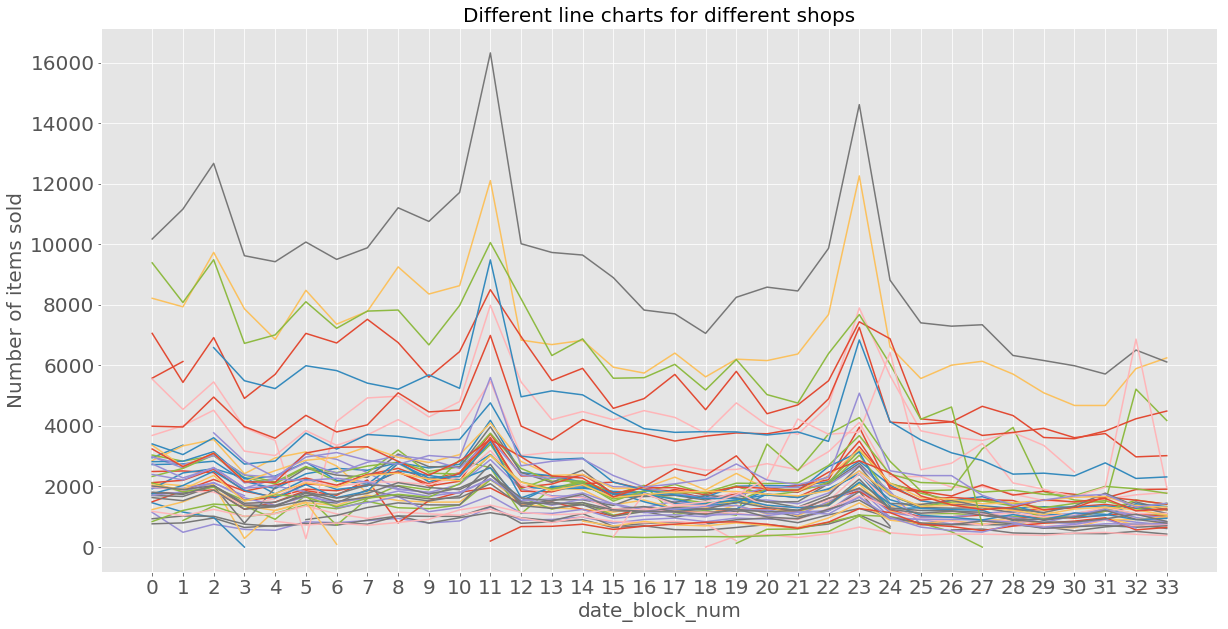

In [18]:
plt.style.use('ggplot')
salesByMonthAndShop.unstack(level=1).plot(kind='line',legend=None,figsize=(20,10),fontsize=20)
plt.xticks(range(0,34))
plt.xlabel('date_block_num',fontsize=20)
plt.ylabel('Number of items sold',fontsize=20)
plt.title('Different line charts for different shops',fontsize=20)
plt.show()

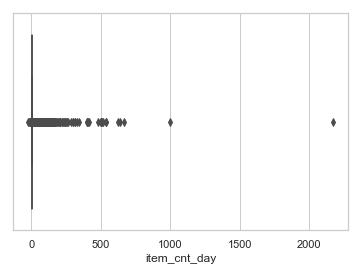

In [19]:
# Outlier Detection for item_cnt_day
df.head()
sns.set(style="whitegrid")
ax = sns.boxplot(df['item_cnt_day'])

Based on the Box plot above we can see that there is an outlier in the quantity of items sold by day.

In [20]:
# Counting number of records with item_cnt_day > 2000
sales_by_day_above_2000 = df[df['item_cnt_day'] > 2000].shape[0]
print('count of item_cnt_day > 2000: ', sales_by_day_above_2000)

# Dropping the outlier - take only item counts of <= 1000
df = df[df['item_cnt_day'] <= 1000]
df.shape[0]

count of item_cnt_day > 2000:  1


2935848

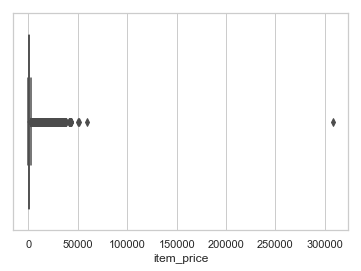

In [21]:
# Outlier Detection for item_price
sns.set(style="whitegrid")
ax = sns.boxplot(df['item_price'])

Again in this case we can see an outlier for item_price > 300,000

In [22]:
# Count the number of outliers with item_price > 300,000
item_price_above_300k = df[df['item_price'] > 300000].shape[0]
print('count of item_price > 300000: ', item_price_above_300k)

# Dropping the outlier - take only item_price of <= 100000
df = df[df['item_price'] <= 100000]
# Also take only item_price >= 0
df = df[df['item_price'] >= 0]
df.shape[0]

count of item_price > 300000:  1


2935846

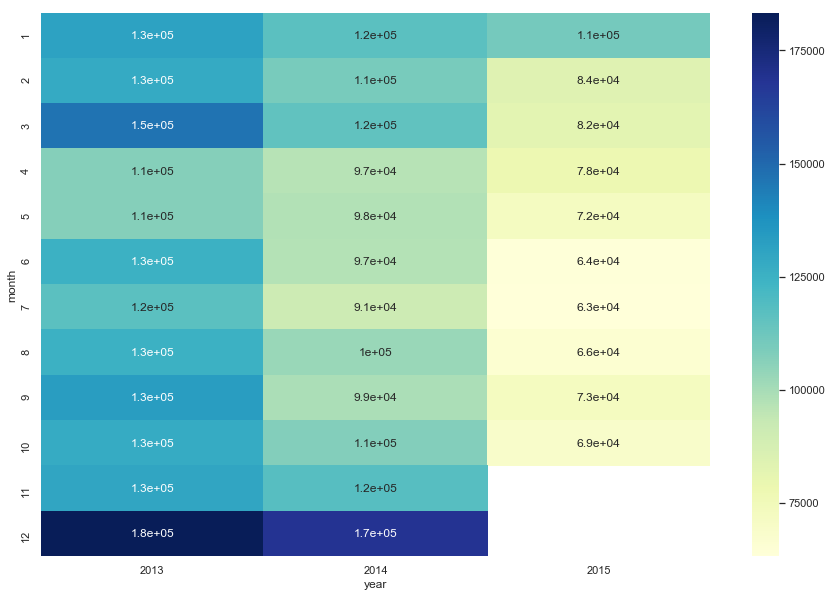

In [23]:
df1 = df[['day','month','year','item_cnt_day']]
df1 = df1.groupby(['year','month']).sum()
df2 = df1.reset_index()
df2.head()
df3 = df2.pivot('month','year','item_cnt_day')

fig, ax = plt.subplots(figsize=(15,10)) 
ax = sns.heatmap(df3,annot=True,cmap="YlGnBu",ax=ax)

In [24]:
sale_by_month = train.groupby(['date_block_num','shop_id','item_id']).agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
sale_by_month.columns = sale_by_month.columns.droplevel(0)
sale_by_month = sale_by_month.reset_index()
sale_by_month = sale_by_month.rename(columns = {"min":'min_date', "max":"max_date", "mean": "mean_item_price", "sum":"sum_item_cnt_day"}) 

df_neg = sale_by_month[sale_by_month['sum_item_cnt_day'] < 0]
df_pos = sale_by_month[sale_by_month['sum_item_cnt_day'] >= 0]
neg = df_neg.shape[0]
pos = df_pos.shape[0]
percentage_neg = (neg/(neg+pos)) * 100
print('Percentage of records with negative item_cnt_day: ', str(percentage_neg) + ' %' )
# df_neg.head()

Percentage of records with negative item_cnt_day:  0.05686323738879043 %


In [25]:
sale_by_month.shape[0]

1609124

In [26]:
# Drop the negative sum_item_cnt_day
sale_by_month = sale_by_month[sale_by_month['sum_item_cnt_day'] >= 0]
print('Row count:', sale_by_month.shape[0])

Row count: 1608209


In [27]:
# Remove Duplicate Records
sale_by_month.drop_duplicates()
sale_by_month.shape[0]


1608209

Text(0, 0.5, 'Count of Items Sold')

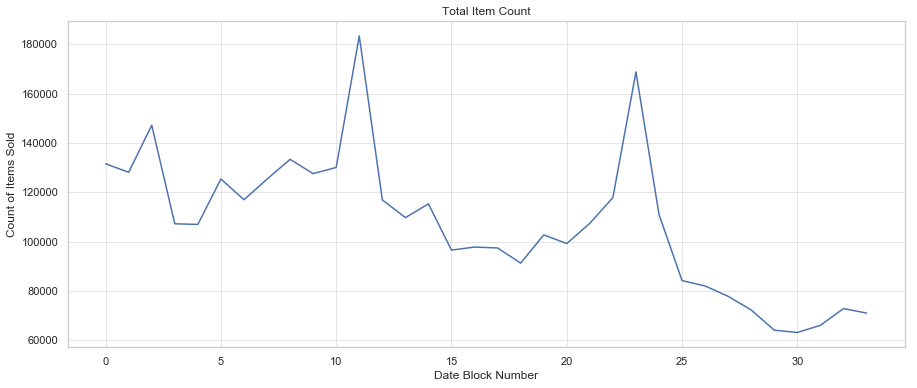

In [28]:
sale_by_month.head()
sale_by_date_block = sale_by_month[['date_block_num','sum_item_cnt_day']].groupby('date_block_num').sum()
#sale_by_date_block = sale_by_date_block.reset_index()
#plt.plot(sale_by_date_block['date_block_num'],sale_by_date_block['sum_item_cnt_day'])

plt.figure(figsize=(15,6))
plt.plot(sale_by_date_block) 
plt.grid(True, alpha=0.5)
plt.title('Total Item Count')
plt.xlabel('Date Block Number')
plt.ylabel('Count of Items Sold')


In [29]:
sale_by_month.head()
sale_by_month.shape[0]

#sale_by_month.info()

1608209

Data Cleaning:
1. Remove outliers:
    item_price > 300,000
    item_prie < 0
    item_cnt_day > 2000

2. Remove sales for item_cnt_day < 0

3. Remove Duplicates

In [30]:
# Reading Test Set
test = pd.read_csv(r'C:\Users\Veekesh\data\test.csv')
test.head()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [31]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [32]:
# unique items
test['item_id'].unique().shape[0]

5100

In [33]:
# unique shops
test['shop_id'].unique().shape[0]

42

In [34]:
# Row count 
test.shape[0]

214200

In [35]:
# Remove Duplicates
test.drop_duplicates()
test.shape[0]

214200

# Phase 2: Feature Engineering

1. Data Type Casting
2. Remove Trend
3. Remove Seasonality
4. Integrating detail/description with training set
4. Create Lag Features

Text(0, 0.5, 'item_cnt_day')

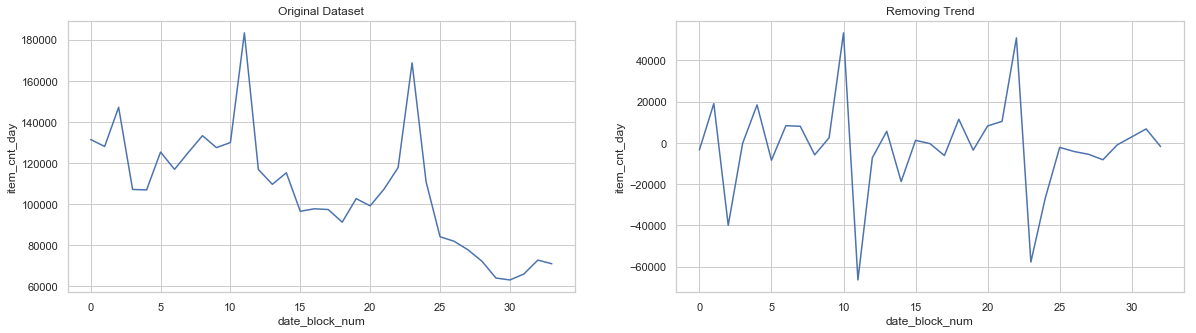

In [36]:
# Removing Trend
monthly_train_series=train.groupby(["date_block_num"])["item_cnt_day"].sum()
X = monthly_train_series.values

trend_diff = []
# Assuming 1 month trend difference
trend_month = 1

for i in range(trend_month, len(X)):
    new_value = X[i] - X[i - trend_month]
    trend_diff.append(new_value)

f = plt.figure(figsize=(20,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(X)    
ax2.plot(trend_diff)    
ax1.set_title('Original Dataset')
ax1.set_xlabel('date_block_num')
ax1.set_ylabel('item_cnt_day')

ax2.set_title('Removing Trend')
ax2.set_xlabel('date_block_num')
ax2.set_ylabel('item_cnt_day')

#trend_diff

34


Text(0, 0.5, 'item_cnt_day')

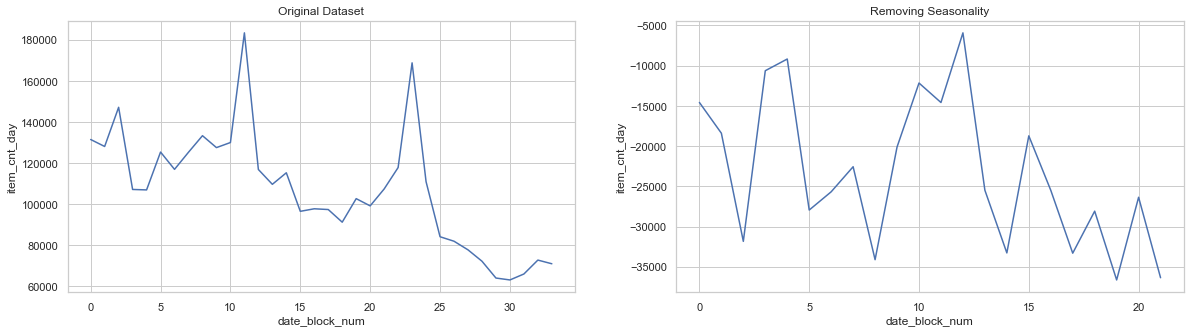

In [37]:
# Removing Seasonality
monthly_train_series=train.groupby(["date_block_num"])["item_cnt_day"].sum()
X = monthly_train_series.values

print(len(X))

seasonal_diff = []
# Assuming 12 months of seasonal change
seasonal_months = 12

for i in range(seasonal_months, len(X)):
    new_value = X[i] - X[i - seasonal_months]
    seasonal_diff.append(new_value)

f = plt.figure(figsize=(20,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(X)    
ax2.plot(seasonal_diff)    
ax1.set_title('Original Dataset')
ax1.set_xlabel('date_block_num')
ax1.set_ylabel('item_cnt_day')

ax2.set_title('Removing Seasonality')
ax2.set_xlabel('date_block_num')
ax2.set_ylabel('item_cnt_day')

#seasonal_diff

In [38]:
# Integrating Detailed Description with Training Set
# Reading Test Set
item_categories = pd.read_csv(r'C:\Users\Veekesh\data\item_categories.csv')
item = pd.read_csv(r'C:\Users\Veekesh\data\items.csv')
shops = pd.read_csv(r'C:\Users\Veekesh\data\shops.csv')

sale_by_month.head()
item_categories.head()
shops.head()
item.head()

monthly_data = pd.merge(sale_by_month, shops, on='shop_id', how='left')
monthly_data = pd.merge(monthly_data, item, on='item_id', how='left')
monthly_data = pd.merge(monthly_data, item_categories, on='item_category_id', how='left')
#monthly_data.shape[0]
#1609124
monthly_data.head()

,date_block_num,shop_id,item_id,min_date,max_date,mean_item_price,sum_item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


In [39]:
monthly_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'min_date', 'max_date',
       'mean_item_price', 'sum_item_cnt_day', 'shop_name', 'item_name',
       'item_category_id', 'item_category_name'],
      dtype='object')

In [40]:
monthly_data['city'] = monthly_data['shop_name'].apply(lambda x: str(x).split(' ')[0].replace('!',''))
monthly_data['shop'] = monthly_data['shop_name'].apply(lambda x: ''.join(str(x).split(' ')[1:]))
monthly_data = monthly_data.drop('shop_name',1)

In [41]:
monthly_data.head()

,date_block_num,shop_id,item_id,min_date,max_date,mean_item_price,sum_item_cnt_day,item_name,item_category_id,item_category_name,city,shop
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0,1+1,40,Кино - DVD,Якутск,"Орджоникидзе,56фран"
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0,1+1 (BD),37,Кино - Blu-Ray,Якутск,"Орджоникидзе,56фран"
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,Якутск,"Орджоникидзе,56фран"
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,Якутск,"Орджоникидзе,56фран"
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,Якутск,"Орджоникидзе,56фран"


In [42]:
monthly_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'min_date', 'max_date',
       'mean_item_price', 'sum_item_cnt_day', 'item_name', 'item_category_id',
       'item_category_name', 'city', 'shop'],
      dtype='object')

In [43]:
sale_by_month['total_sales_day'] = sale_by_month['mean_item_price'] * sale_by_month['sum_item_cnt_day']
sale_by_month.head()
df1 = sale_by_month[['mean_item_price','sum_item_cnt_day','total_sales_day']]
df1.head()
shifted = df1.shift(1)
window = shifted.rolling(window=3)
means = window.mean()

means = means.rename(columns={'mean_item_price':'mean_item_price_lag_3','sum_item_cnt_day':'sum_item_cnt_day_lag_3', 'total_sales_day':'total_sales_day_lag_3'})
dataframe = concat([sale_by_month,means], axis=1)
dataframe.head(100)

,date_block_num,shop_id,item_id,min_date,max_date,mean_item_price,sum_item_cnt_day,total_sales_day,mean_item_price_lag_3,sum_item_cnt_day_lag_3,total_sales_day_lag_3
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0,1326.0,NaN,NaN,NaN
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0,1041.0,NaN,NaN,NaN
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0,247.0,NaN,NaN,NaN
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0,221.0,271.666667,3.333333,871.333333
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0,257.0,271.666667,1.666667,503.000000
5,0,0,61,2013-01-10,2013-01-10,195.0,1.0,195.0,198.833333,1.333333,241.666667
6,0,0,75,2013-01-17,2013-01-17,76.0,1.0,76.0,181.500000,1.333333,224.333333
7,0,0,88,2013-01-16,2013-01-16,76.0,1.0,76.0,133.166667,1.333333,176.000000
8,0,0,95,2013-01-06,2013-01-06,193.0,1.0,193.0,115.666667,1.000000,115.666667
9,0,0,96,2013-01-10,2013-01-10,70.0,1.0,70.0,115.000000,1.000000,115.000000


In [44]:
monthly_data = pd.merge(dataframe, shops, on='shop_id', how='left')
monthly_data = pd.merge(monthly_data, item, on='item_id', how='left')
monthly_data = pd.merge(monthly_data, item_categories, on='item_category_id', how='left')

monthly_data.head()

,date_block_num,shop_id,item_id,min_date,max_date,mean_item_price,sum_item_cnt_day,total_sales_day,mean_item_price_lag_3,sum_item_cnt_day_lag_3,total_sales_day_lag_3,shop_name,item_name,item_category_id,item_category_name
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0,1326.0,NaN,NaN,NaN,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0,1041.0,NaN,NaN,NaN,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0,247.0,NaN,NaN,NaN,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0,221.0,271.666667,3.333333,871.333333,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0,257.0,271.666667,1.666667,503.000000,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


In [45]:
monthly_data['city'] = monthly_data['shop_name'].apply(lambda x: str(x).split(' ')[0].replace('!',''))
monthly_data['shop'] = monthly_data['shop_name'].apply(lambda x: ''.join(str(x).split(' ')[1:]))
monthly_data = monthly_data.drop('shop_name',1)

# Dummy varaibles for city
dummies = pd.get_dummies(monthly_data.city).rename(columns=lambda x: 'location_' + str(x))
# Adding n-1 dummy variables to the original dataframe
monthly_data = pd.concat([monthly_data, dummies.iloc[:,:-1]], axis=1)

monthly_data.head()

,date_block_num,shop_id,item_id,min_date,max_date,mean_item_price,sum_item_cnt_day,total_sales_day,mean_item_price_lag_3,sum_item_cnt_day_lag_3,...,location_Самара,location_Сергиев,location_Сургут,location_Томск,location_Тюмень,location_Уфа,location_Химки,location_Цифровой,location_Чехов,location_Якутск
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0,1326.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0,1041.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0,247.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0,221.0,271.666667,3.333333,...,0,0,0,0,0,0,0,0,0,1
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0,257.0,271.666667,1.666667,...,0,0,0,0,0,0,0,0,0,1


In [46]:
monthly_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'min_date', 'max_date',
       'mean_item_price', 'sum_item_cnt_day', 'total_sales_day',
       'mean_item_price_lag_3', 'sum_item_cnt_day_lag_3',
       'total_sales_day_lag_3', 'item_name', 'item_category_id',
       'item_category_name', 'city', 'shop', 'location_Адыгея',
       'location_Балашиха', 'location_Волжский', 'location_Вологда',
       'location_Воронеж', 'location_Выездная', 'location_Жуковский',
       'location_Интернет-магазин', 'location_Казань', 'location_Калуга',
       'location_Коломна', 'location_Красноярск', 'location_Курск',
       'location_Москва', 'location_Мытищи', 'location_Н.Новгород',
       'location_Новосибирск', 'location_Омск', 'location_РостовНаДону',
       'location_СПб', 'location_Самара', 'location_Сергиев',
       'location_Сургут', 'location_Томск', 'location_Тюмень', 'location_Уфа',
       'location_Химки', 'location_Цифровой', 'location_Чехов',
       'location_Якутск'],
      dtype='object')

In [47]:
# Select Feature for Clustering
features = monthly_data[[
'date_block_num','shop_id', 'item_id','mean_item_price','total_sales_day',
'location_Адыгея','location_Балашиха', 'location_Волжский', 'location_Вологда',
'location_Воронеж', 'location_Выездная', 'location_Жуковский',
'location_Интернет-магазин', 'location_Казань', 'location_Калуга',
'location_Коломна', 'location_Красноярск', 'location_Курск',
'location_Москва', 'location_Мытищи', 'location_Н.Новгород',
'location_Новосибирск', 'location_Омск', 'location_РостовНаДону',
'location_СПб', 'location_Самара', 'location_Сергиев',
'location_Сургут', 'location_Томск', 'location_Тюмень', 'location_Уфа',
'location_Химки', 'location_Цифровой', 'location_Чехов',
'location_Якутск','shop','mean_item_price_lag_3','total_sales_day_lag_3']]
features.head()

,date_block_num,shop_id,item_id,mean_item_price,total_sales_day,location_Адыгея,location_Балашиха,location_Волжский,location_Вологда,location_Воронеж,...,location_Томск,location_Тюмень,location_Уфа,location_Химки,location_Цифровой,location_Чехов,location_Якутск,shop,mean_item_price_lag_3,total_sales_day_lag_3
0,0,0,32,221.0,1326.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN
1,0,0,33,347.0,1041.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN
2,0,0,35,247.0,247.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN
3,0,0,43,221.0,221.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",271.666667,871.333333
4,0,0,51,128.5,257.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",271.666667,503.000000


In [48]:
features.shape[0]

1608209

In [49]:
featuresNan = features[np.isnan(features['mean_item_price_lag_3'])==True]
featuresNan

,date_block_num,shop_id,item_id,mean_item_price,total_sales_day,location_Адыгея,location_Балашиха,location_Волжский,location_Вологда,location_Воронеж,...,location_Томск,location_Тюмень,location_Уфа,location_Химки,location_Цифровой,location_Чехов,location_Якутск,shop,mean_item_price_lag_3,total_sales_day_lag_3
0,0,0,32,221.0,1326.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN
1,0,0,33,347.0,1041.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN
2,0,0,35,247.0,247.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",NaN,NaN


In [50]:
# Remove NaN Values
features = features[np.isnan(features['mean_item_price_lag_3'])==False]
features.head()

,date_block_num,shop_id,item_id,mean_item_price,total_sales_day,location_Адыгея,location_Балашиха,location_Волжский,location_Вологда,location_Воронеж,...,location_Томск,location_Тюмень,location_Уфа,location_Химки,location_Цифровой,location_Чехов,location_Якутск,shop,mean_item_price_lag_3,total_sales_day_lag_3
3,0,0,43,221.0,221.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",271.666667,871.333333
4,0,0,51,128.5,257.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",271.666667,503.000000
5,0,0,61,195.0,195.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",198.833333,241.666667
6,0,0,75,76.0,76.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",181.500000,224.333333
7,0,0,88,76.0,76.0,0,0,0,0,0,...,0,0,0,0,0,0,1,"Орджоникидзе,56фран",133.166667,176.000000


# Phase 3: Clustering

1. Clustering on shop_id and total_sales_day
2. Clustering on shop_id and item_id

In [51]:
# Prepare the data

# X = features[[
# 'location_Адыгея','location_Балашиха', 'location_Волжский', 'location_Вологда',
# 'location_Воронеж', 'location_Выездная', 'location_Жуковский',
# 'location_Интернет-магазин', 'location_Казань', 'location_Калуга',
# 'location_Коломна', 'location_Красноярск', 'location_Курск',
# 'location_Москва', 'location_Мытищи', 'location_Н.Новгород',
# 'location_Новосибирск', 'location_Омск', 'location_РостовНаДону',
# 'location_СПб', 'location_Самара', 'location_Сергиев',
# 'location_Сургут', 'location_Томск', 'location_Тюмень', 'location_Уфа',
# 'location_Химки', 'location_Цифровой', 'location_Чехов',
# 'location_Якутск']].values.tolist()

X = features['shop_id']

Y = features['total_sales_day'].values.tolist() 

data_cluster = {'x': X,
                'y': Y
               }
  
df_cluster = pd.DataFrame(data_cluster,columns=['x','y'])
#df_cluster.to_csv('df_cluster.csv', index=True)
df_cluster.head()

,x,y
3,0,221.0
4,0,257.0
5,0,195.0
6,0,76.0
7,0,76.0


In [52]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=4).fit(df_cluster)
y_kmeans = kmeans.predict(df_cluster)

In [53]:
centroids = kmeans.cluster_centers_
print(centroids)

[[3.28138217e+01 1.62236206e+03]
 [3.13649425e+01 5.53450185e+05]
 [2.95000000e+01 2.03042084e+06]
 [3.12782673e+01 1.01483323e+05]]


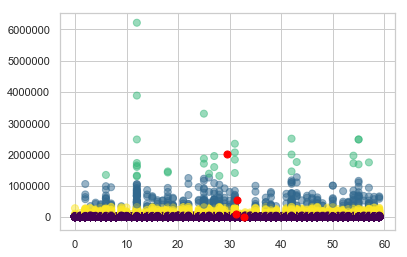

In [54]:
plt.scatter(df_cluster['x'], df_cluster['y'], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

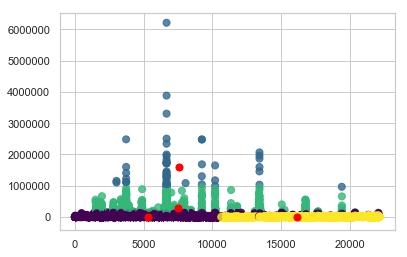

In [55]:
X = features['item_id']
Y = features['total_sales_day'].values.tolist() 
data_cluster = {'x': X,'y': Y}
df_cluster = pd.DataFrame(data_cluster,columns=['x','y'])
kmeans = KMeans(n_clusters=4).fit(df_cluster)
y_kmeans = kmeans.predict(df_cluster)
centroids = kmeans.cluster_centers_                         
plt.scatter(df_cluster['x'], df_cluster['y'], c=y_kmeans, s=50, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)                        

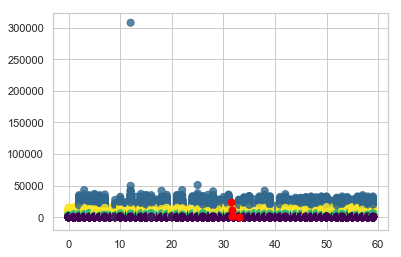

In [56]:
X = features['shop_id']
Y = features['mean_item_price'].values.tolist() 
data_cluster = {'x': X,'y': Y}
df_cluster = pd.DataFrame(data_cluster,columns=['x','y'])
kmeans = KMeans(n_clusters=4).fit(df_cluster)
y_kmeans = kmeans.predict(df_cluster)
centroids = kmeans.cluster_centers_                         
plt.scatter(df_cluster['x'], df_cluster['y'], c=y_kmeans, s=50, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)     

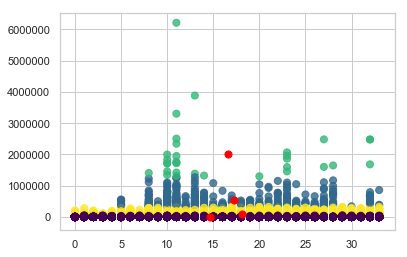

In [57]:
X = features['date_block_num']
Y = features['total_sales_day'].values.tolist() 
data_cluster = {'x': X,'y': Y}
df_cluster = pd.DataFrame(data_cluster,columns=['x','y'])
kmeans = KMeans(n_clusters=4).fit(df_cluster)
y_kmeans = kmeans.predict(df_cluster)
centroids = kmeans.cluster_centers_                         
plt.scatter(df_cluster['x'], df_cluster['y'], c=y_kmeans, s=50, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)   

In [57]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

# Using KMeans on selected Features

In [107]:
features.head()
df = features.drop('shop',axis=1)
df = df.drop(['mean_item_price_lag_3','total_sales_day_lag_3'],axis=1)
df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'mean_item_price',
       'total_sales_day', 'location_Адыгея', 'location_Балашиха',
       'location_Волжский', 'location_Вологда', 'location_Воронеж',
       'location_Выездная', 'location_Жуковский', 'location_Интернет-магазин',
       'location_Казань', 'location_Калуга', 'location_Коломна',
       'location_Красноярск', 'location_Курск', 'location_Москва',
       'location_Мытищи', 'location_Н.Новгород', 'location_Новосибирск',
       'location_Омск', 'location_РостовНаДону', 'location_СПб',
       'location_Самара', 'location_Сергиев', 'location_Сургут',
       'location_Томск', 'location_Тюмень', 'location_Уфа', 'location_Химки',
       'location_Цифровой', 'location_Чехов', 'location_Якутск'],
      dtype='object')

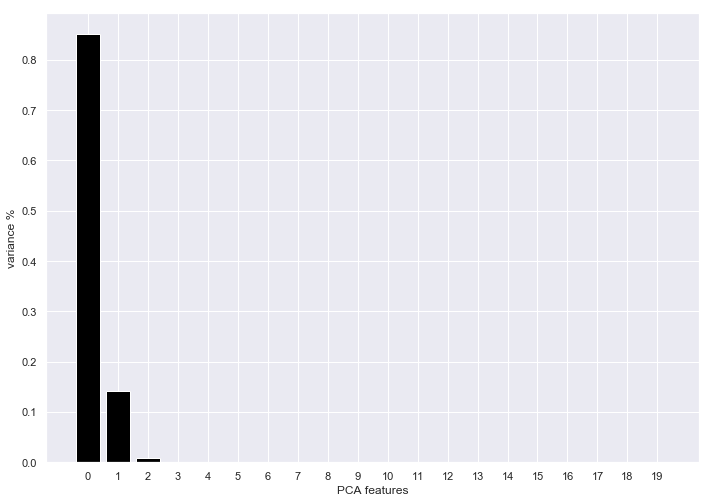

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#X_std = StandardScaler().fit_transform(df)

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(df)

#print (pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2','PC-3']))

# Plot the explained variances
pca_features = range(pca.n_components_)
plt.bar(pca_features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(pca_features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

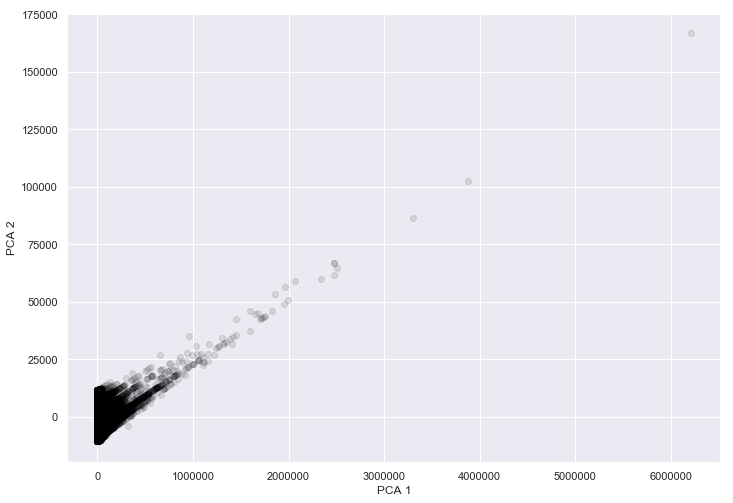

In [109]:
# optimal number of components which capture the greatest amount of variance in the data = 2 
# let's use 4

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

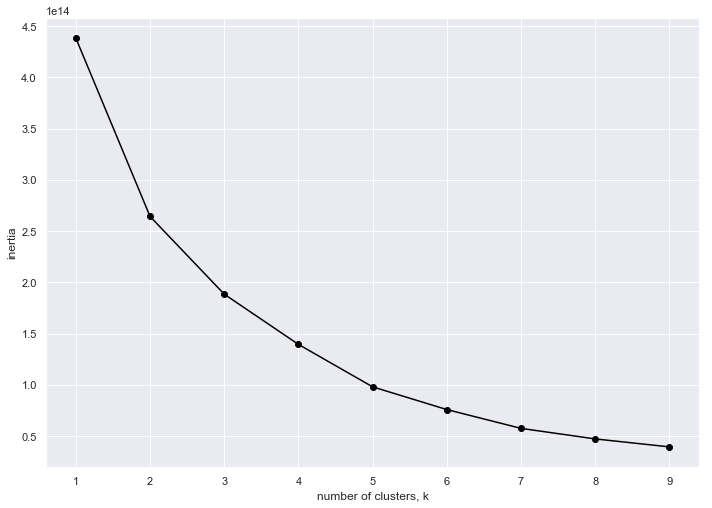

In [110]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

[[-1.42294197e+02 -3.25418805e+00]
 [ 7.60118110e+05  1.73834725e+04]]


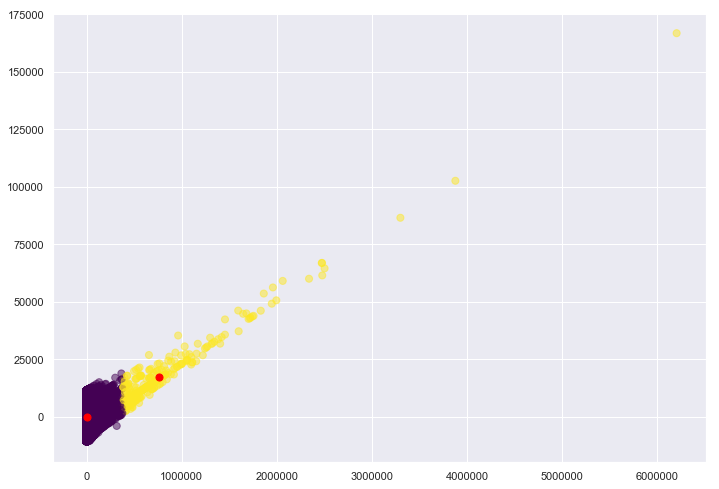

In [127]:
# type(PCA_components.iloc[:,1])
# PCA_components.iloc[:,:2].head()

df_cluster = PCA_components.iloc[:,:2]

kmeans = KMeans(n_clusters=2).fit(df_cluster)
y_kmeans = kmeans.predict(df_cluster)

centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df_cluster[0], df_cluster[1], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
